<a href="https://colab.research.google.com/github/krabhiparashar/Credit-Risk-Early-Warning-System/blob/main/Credit_Risk_Early_Warning_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Risk Early Warning System

---
## Problem Statement
Financial institutions need an early warning system to identify customers who may have a higher probability of loan default in the future.

---

This project builds a rule-based credit risk prediction model using historical loan data.  
The model does not classify anyone as a defaulter, but assigns a risk score to support proactive decision-making.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (8,5)

-------


##Libraries are imported for:
- Data manipulation (Pandas, NumPy)
- Visualization (Matplotlib, Seaborn)


---


## Dataset Loading

The dataset contains historical loan information including loan amount, income, interest rate, tenure, and loan status.


In [ ]:
df = pd.read_csv('Credit Risk.csv')
df.head()


,id,loan_amnt,term,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,total_pymnt
0,1077501,5000,36 months,10.65%,162.87,RENT,24000.0,Verified,Dec-11,Fully Paid,credit_card,5863.155187
1,1077430,2500,60 months,15.27%,59.83,RENT,30000.0,Source Verified,Dec-11,Charged Off,car,1008.710000
2,1077175,2400,36 months,15.96%,84.33,RENT,12252.0,Not Verified,Dec-11,Fully Paid,small_business,3005.666844
3,1076863,10000,36 months,13.49%,339.31,RENT,49200.0,Source Verified,Dec-11,Fully Paid,other,12231.890000
4,1075358,3000,60 months,12.69%,67.79,RENT,80000.0,Source Verified,Dec-11,Current,other,3513.330000


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   39717 non-null  int64  
 1   loan_amnt            39717 non-null  int64  
 2   term                 39717 non-null  object 
 3   int_rate             39717 non-null  object 
 4   installment          39717 non-null  float64
 5   home_ownership       39717 non-null  object 
 6   annual_inc           39717 non-null  float64
 7   verification_status  39717 non-null  object 
 8   issue_d              39717 non-null  object 
 9   loan_status          39717 non-null  object 
 10  purpose              39717 non-null  object 
 11  total_pymnt          39717 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 3.6+ MB


---


## Dataset Observations
- Mix of numerical and categorical features
- Loan status is historical and used only as reference
- Some columns need cleaning and transformation


---


## Assumptions

1. Past loan behavior gives insight into future risk
2. Higher loan-to-income ratio increases risk
3. Longer tenure implies prolonged financial burden
4. Higher interest rate indicates higher credit risk
5. This model provides **risk indication only**, not final decisions


In [ ]:
df['loan_income_ratio'] = df['loan_amnt'] / df['annual_inc']


##Loan-to-income ratio is created to measure financial stress.


----

## Risk Scoring Logic

Each customer is assigned risk points based on predefined financial rules.
Higher points indicate higher potential risk.


In [ ]:
df['risk_score'] = 0

df['int_rate'] = (
    df['int_rate']
    .str.replace('%', '', regex=False)
    .astype(float)
)


df.loc[df['annual_inc'] < 30000, 'risk_score'] += 25
df.loc[(df['annual_inc'] >= 30000) & (df['annual_inc'] < 60000), 'risk_score'] += 15

df.loc[df['loan_income_ratio'] > 0.5, 'risk_score'] += 20
df.loc[df['term'] == 60, 'risk_score'] += 10
df.loc[df['int_rate'] > 15, 'risk_score'] += 15
df.loc[df['home_ownership'] == 'RENT', 'risk_score'] += 10
df.loc[df['loan_status'] == 'Charged Off', 'risk_score'] += 30

df['risk_score'] = df['risk_score'].clip(0,100)


##A capped risk score (0–100) is computed using transparent, rule-based logic.


In [ ]:
def risk_category(score):
    if score <= 30:
        return 'Low Risk'
    elif score <= 60:
        return 'Medium Risk'
    else:
        return 'High Risk'

df['risk_category'] = df['risk_score'].apply(risk_category)
df[['risk_score','risk_category']].head()


,risk_score,risk_category
0,35,Medium Risk
1,70,High Risk
2,50,Medium Risk
3,25,Low Risk
4,10,Low Risk


## Risk Score Distribution


In [ ]:
def calculate_risk_score(df):
    score = np.zeros(len(df))
    score += np.where(df['annual_inc'] < 30000, 25, 0)
    score += np.where(df['loan_income_ratio'] > 0.5, 20, 0)
    return np.clip(score, 0, 100)


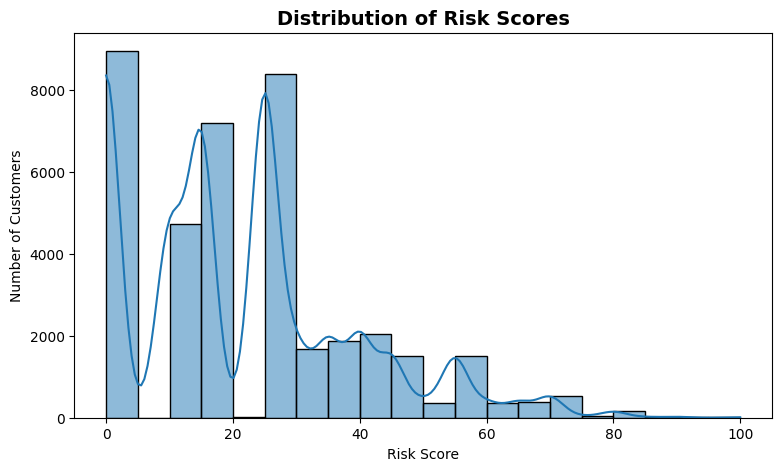

In [ ]:
plt.figure(figsize=(9,5))
sns.histplot(
    df['risk_score'],
    bins=20,
    kde=True,
    color='#1F77B4',   # professional blue
    edgecolor='black'
)
plt.title('Distribution of Risk Scores', fontsize=14, fontweight='bold')
plt.xlabel('Risk Score')
plt.ylabel('Number of Customers')
plt.show()


###The portfolio is predominantly composed of low to medium risk customers, indicating overall healthy credit behavior.

### Insight

The risk score distribution is right-skewed, indicating that the majority of customers fall within the low to medium risk range.
This suggests an overall healthy loan portfolio, with a smaller subset of customers exhibiting elevated risk levels.
The long tail on the higher end highlights the importance of targeted monitoring for high-risk cases.


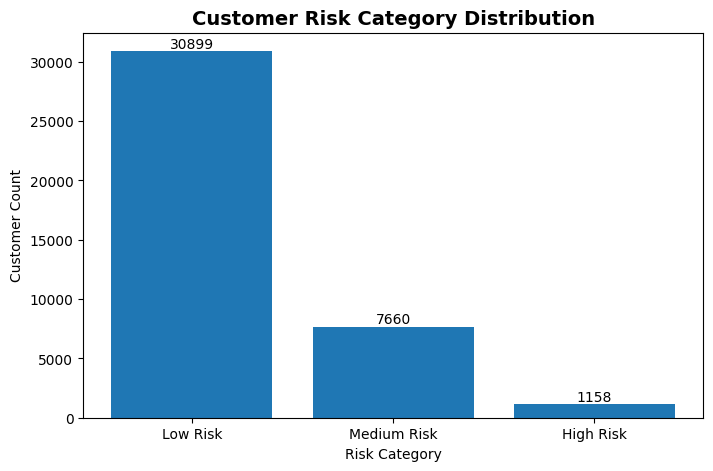

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))

counts = df['risk_category'].value_counts()
ax.bar(counts.index, counts.values)

# Add value labels
for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom'
    )

ax.set_title('Customer Risk Category Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Risk Category')
ax.set_ylabel('Customer Count')

plt.show()


### Insight

Most customers are classified as Low Risk, reflecting stable repayment behavior across the portfolio.
Medium Risk customers represent a critical transition group that may benefit from early intervention measures.
Although High Risk customers form a smaller segment, they pose a disproportionate potential financial impact and require focused attention.


---


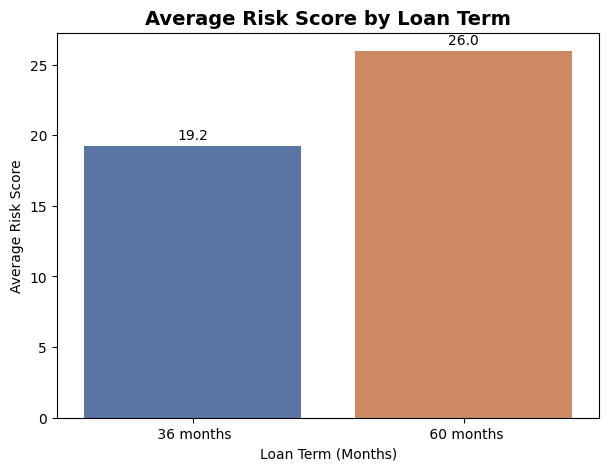

In [ ]:
# Calculate average risk score by loan term
avg_risk = df.groupby('term')['risk_score'].mean().reset_index()

plt.figure(figsize=(7,5))

sns.barplot(
    data=avg_risk,
    x='term',
    y='risk_score',
    hue='term',            # fixes future warning
    palette=['#4C72B0', '#DD8452'],
    legend=False
)

plt.title('Average Risk Score by Loan Term', fontsize=14, fontweight='bold')
plt.xlabel('Loan Term (Months)')
plt.ylabel('Average Risk Score')

# Add value labels
for index, row in avg_risk.iterrows():
    plt.text(
        index,
        row['risk_score'] + 0.5,
        round(row['risk_score'], 1),
        ha='center',
        fontsize=10
    )

plt.show()


### Insight

Loans with a 60-month tenure exhibit a significantly higher average risk score compared to 36-month loans.
Longer repayment periods increase exposure to income volatility and financial uncertainty, thereby elevating credit risk.
This indicates that loan tenure is a key driver of risk and should be carefully evaluated during credit assessment.


---


## Key Insights

- High loan-to-income ratio is a strong risk indicator
- Longer loan tenure increases repayment stress
- Income stability plays a major role in risk reduction



---


## Business Impact

- Enables early identification of high-risk customers
- Helps lenders take preventive actions (reminders, restructuring)
- Reduces potential loan defaults and financial losses
- Improves responsible lending and financial inclusion


---


## Model Limitations

- Risk score does not adapt automatically over time
- External factors (economic shocks, medical emergencies) are not included
- Model should be reviewed periodically by domain experts


---


## Conclusion

This project helps identify customers who may face repayment risk in the future by using simple financial rules and past loan data.
It supports early action by lenders, improves decision-making, and promotes responsible and transparent lending.
